# Project week 7

For the project this week, you are given a video of a ball rolling over a surface. Your job is now to detect the ball, track the position, velocity and acceleration using a Kalman filter, and finally draw the currently tracked position and predicted position of the ball in the images, while also printing the whole predicted state in either the image or the terminal.

The video "rolling_ball_result.mp4" shows what the end result could look like.

You have to make the Kalman filter yourselves, i.e. initialize the matrices and make a update and predict function. You are of course allowed to use numpy.

You can use the code below and fill in the missing parts.



Iteration 0: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Iteration 1: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Iteration 2: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Iteration 3: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Iteration 4: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Iteration 5: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Iteration 6: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Iteration 7: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Iteration 8: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Iteration 9: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Iteration 10: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Iteration 11: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Iteration 12: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Iteration 13: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Iteration 14: 
[[2194.23546636]
 [ 745.16878429]
 [ 289.80468424]
 [  98.41851868]
 [  19.13804519]
 [   6.49933614]]
Iteration 15: 
[[1899.08283532]
 [ 697.43907793]
 [ -25.0013319 ]
 [  21.0014057 ]
 [ -17.68218055]
 [  -2.75317935]]
Iteration 16: 
[[1884.36617514]
 [ 691.2427743

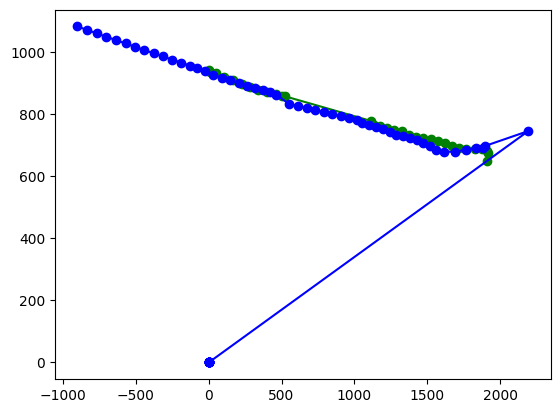

[[1914, 650], [1915, 675], [1912, 680], [1879, 687], [1830, 687], [1769, 686], [1716, 691], [1671, 698], [1623, 707], [1575, 714], [1527, 721], [1473, 723], [1424, 727], [1374, 732], [1327, 745], [1274, 750], [1225, 754], [1178, 761], [1132, 766], [1112, 778], [524, 857], [504, 859], [459, 866], [400, 870], [340, 877], [283, 888], [225, 898], [166, 908], [107, 919], [53, 931], [8, 936], [2, 942]]


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def update(x, P, Z, H, R, I):
    ### Insert update function
    y = Z - H @ x
    S = H @ P @ H.T + R
    S_inv = np.linalg.pinv(S)
    K = P @ H.T @ S_inv
    x_new = x + K @ y
    p_new = (I - K @ H) @ P
    return x_new, p_new
    
def predict(x, P, F, u):
    ### insert predict function
    x_new = F @ x + u
    p_new = F @ P @ F.T
    return x_new, p_new
    
    
    
### Initialize Kalman filter ###
# delta t 
dt = 1
# The initial state (6x1).
# state is defined as pos x, pos y, vel x, vel y, acc x, acc y
x = np.array([[0],[0],[0],[0],[0],[0]])

# The initial uncertainty (6x6).
P = 1000 * np.eye(6)

# The external motion (6x1).
u = np.array([[0],[0],[0],[0],[0],[0]])

# The transition matrix (6x6). 
F = np.array([[1,0,1*dt,0,0.5*dt**2,0],
              [0,1,0,1*dt,0,0.5*dt**2],
              [0,0,1,0,1*dt,0],
              [0,0,0,1,0,1*dt],
              [0,0,0,0,1,0],
              [0,0,0,0,0,1]])

# The observation matrix (2x6).
# we can only observe x and y
H = np.array([[1, 0, 0,0,0,0], [0, 1, 0,0,0,0]])

# The measurement uncertainty.
R = 1 * np.eye(2)

I = np.eye(6)

prediction = []
measurement = []


### Initialize Detection ###
# find thresholds in HSV space
lower_red1 = np.array([0, 120, 50])
upper_red1 = np.array([10, 255, 255])
# kernels for morphological closing and opening
kernel = np.ones((7,7),np.uint8)

# Load the video
cap = cv2.VideoCapture('rolling_ball.mp4')
cap.set(3, 1280)  # width
cap.set(4, 720)  # height
if not cap.isOpened():
    print("Cannot open video")
    exit()

# Looping through all the frames
counter = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
        
    ### Detect the ball ###
    frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask0 = cv2.inRange(frame_hsv, lower_red1, upper_red1)
    # mask1 = cv2.inRange(frame_hsv, lower_red2, upper_red2)
    mask = mask0 #+ mask1
    opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

    contours, hierarchy = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    if len(contours) > 0:
        max_contour = max(contours, key=cv2.contourArea)
        # center of ball
        (xi, yi), radius = cv2.minEnclosingCircle(max_contour)
        center = (int(xi), int(yi))
        radius = int(radius)

        # draw tracked state on frame in GREEN
        cv2.circle(frame, center, 60, (0, 255, 0), 2)
        measurement.append([int(xi), int(yi)])
        # cv2.circle(mask, center, 60, (255, 255, 255), 2)
        ### If the ball is found, update the Kalman filter ###
        z = np.array([[int(xi)],[int(yi)]])
     
        [x, P] = update(x, P, z, H, R, I)
        
    
    ### Predict the next state
    [x, P] = predict(x, P, F, u)
    print("Iteration " + str(counter) + ": ")
    print(x)
 
    prediction.append([x[0, 0], x[1, 0]])
    
    
    ### Draw the current tracked state and the predicted state on the image frame ###
    # prediction in BLUE
    cv2.circle(frame, (int(x[0, 0]), int(x[1, 0])), 60, (255, 0, 0), 2)

    # Show the frame
    cv2.imshow('Frame', frame)  # 65 frames
    cv2.waitKey(50)
    counter += 1
    
cap.release()
cv2.destroyAllWindows()

plt.plot([row[0] for row in measurement], [row[1] for row in measurement], color='green', marker='o')
plt.plot([row[0] for row in prediction], [row[1] for row in prediction], color='blue', marker='o')
plt.show()
print(measurement)

In [2]:
first_column = [row[0] for row in measurement]
print(first_column)

[92, 1915, 1916, 1911, 1879, 1841, 1784, 1732, 1688, 1639, 1592, 1545, 1497, 1448, 1399, 1345, 1291, 1237, 1186, 510, 454, 398, 335, 276, 220, 161, 101, 45, 3]


Try showing the video "rolling_ball_result.mp4" instead, to see what the end result could look like.

## Hints

The first part is to detect the ball. For this part you can look back to the exercises from week 2. More specifically the end of exercise 1. You may have to adjust some parameters in order to only detect the ball.

The next part is to make the Kalman filter. If you did the exercises from monday this week, you already have a suitable update and predict function. You will have to initialize all the different matrices, which we also did in the exercises, however this time we would like the state to include position, velocity and acceleration in both the x- and y-direction (6 states).

Start by defining your state **x** and uncertainty **P**. Then define a transition matrix **F** based on your state. When defining the state transition last time we used the equation for linear motion:

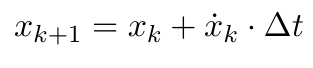

We used dt = 1 (delta t), for simplicity. You can do the same here. However, this time we also have the acceleration and therefore we use:

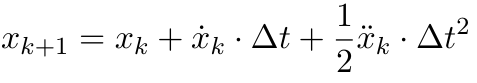

Finally, for a part of the video, the ball is behind something and can't be seen. Obviously we cant update our state here, because there is no measurement. So when there is no measurements available, you should only use the predict function and not the update function, to estimate the state.


# Challenge

If you can't get enough of tracking and Kalman filters, try extending your program, such that it can keep track of multiple balls at the same time. Use the video "rolling_ball_challenge.mp4" to test it. You can take advantage of the balls having different colours.

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def update(x, P, Z, H, R, I):
    ### Insert update function
    y = Z - H @ x
    S = H @ P @ H.T + R
    S_inv = np.linalg.pinv(S)
    K = P @ H.T @ S_inv
    x_new = x + K @ y
    p_new = (I - K @ H) @ P
    return x_new, p_new
    
def predict(x, P, F, u):
    ### insert predict function
    x_new = F @ x + u
    p_new = F @ P @ F.T
    return x_new, p_new
    

def detectBall(frame_hsv, lower, upper):
    mask = cv2.inRange(frame_hsv, lower, upper)
    opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours
    
### Initialize Kalman filter ###
# delta t 
dt = 1
# The initial state (6x1).
# state is defined as pos x, pos y, vel x, vel y, acc x, acc y
x_red = np.array([[0],[0],[0],[0],[0],[0]])
x_blue = np.array([[0],[0],[0],[0],[0],[0]])
x_yellow = np.array([[0],[0],[0],[0],[0],[0]])

# The initial uncertainty (6x6).
P_red = 1000 * np.eye(6)
P_yellow = 1000 * np.eye(6)
P_blue = 1000 * np.eye(6)

# The external motion (6x1).
u = np.array([[0],[0],[0],[0],[0],[0]])

# The transition matrix (6x6). 
F = np.array([[1,0,1*dt,0,0.5*dt**2,0],
              [0,1,0,1*dt,0,0.5*dt**2],
              [0,0,1,0,1*dt,0],
              [0,0,0,1,0,1*dt],
              [0,0,0,0,1,0],
              [0,0,0,0,0,1]])

# The observation matrix (2x6).
# we can only observe x and y
H = np.array([[1, 0, 0,0,0,0], [0, 1, 0,0,0,0]])

# The measurement uncertainty.
R = 1 * np.eye(2)

I = np.eye(6)

prediction = []
measurement = []



### Initialize Detection ###
# find thresholds in HSV space
lower_red1 = np.array([0, 120, 50])
upper_red1 = np.array([10, 255, 255])
lower_yellow1 = np.array([10, 200, 200])
upper_yellow1 = np.array([50, 255, 255])
lower_blue1 = np.array([60, 30, 50])
upper_blue1 = np.array([100, 200, 170])
# kernels for morphological closing and opening
kernel = np.ones((7,7),np.uint8)

# Load the video
cap = cv2.VideoCapture('rolling_ball_challenge.mp4')
if not cap.isOpened():
    print("Cannot open video")
    exit()

not_predicted_red = 0
not_predicted_yellow = 0
not_predicted_blue = 0

# Looping through all the frames
counter = 0
thres = 12
while True:
    ret, frame = cap.read()
    if not ret:
        break
        
    ### Detect the ball ###
    frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # RED
    contours_red = detectBall(frame_hsv, lower_red1, upper_red1)

    # BLUE
    contours_blue = detectBall(frame_hsv, lower_blue1, upper_blue1)

    # YELLOW
    contours_yellow = detectBall(frame_hsv, lower_yellow1, upper_yellow1)

    # RED
    if len(contours_red) > 0:
        not_predicted_red = 0
        max_contour_red = max(contours_red, key=cv2.contourArea)
        (xi_red, yi_red), _ = cv2.minEnclosingCircle(max_contour_red)
        # draw tracked state on frame in GREEN
        cv2.circle(frame, (int(xi_red), int(yi_red)), 60, (0, 255, 0), 2)
        z_red = np.array([[int(xi_red)],[int(yi_red)]])
        [x_red, P_red] = update(x_red, P_red, z_red, H, R, I)
    else:
        not_predicted_red += 1

    ### Predict the next state
    if not_predicted_red < thres:
        [x_red, P_red] = predict(x_red, P_red, F, u)
        cv2.circle(frame, (int(x_red[0, 0]), int(x_red[1, 0])), 60, (0, 0, 255), 2)
    else: 
        x_red = np.array([[0],[0],[0],[0],[0],[0]])
        P_red = 1000 * np.eye(6)

    # YELLOW
    if len(contours_yellow) > 0:
        not_predicted_yellow = 0
        max_contour_yellow = max(contours_yellow, key=cv2.contourArea)
        (xi_yellow, yi_yellow), _ = cv2.minEnclosingCircle(max_contour_yellow)
        # draw tracked state on frame in GREEN
        cv2.circle(frame, (int(xi_yellow), int(yi_yellow)), 60, (0, 255, 0), 2)
        z_yellow = np.array([[int(xi_yellow)],[int(yi_yellow)]])
        [x_yellow, P_yellow] = update(x_yellow, P_yellow, z_yellow, H, R, I)
    else:
        not_predicted_yellow += 1
    
    ### Predict the next state
    if not_predicted_yellow < thres:
        [x_yellow, P_yellow] = predict(x_yellow, P_yellow, F, u)
        cv2.circle(frame, (int(x_yellow[0, 0]), int(x_yellow[1, 0])), 60, (0, 255, 255), 2)
    else:
        x_yellow = np.array([[0],[0],[0],[0],[0],[0]])
        P_yellow = 1000 * np.eye(6)

    # BLUE
    if len(contours_blue) > 0:
        not_predicted_blue = 0
        max_contour_blue = max(contours_blue, key=cv2.contourArea)
        (xi_blue, yi_blue), _ = cv2.minEnclosingCircle(max_contour_blue)
        # draw tracked state on frame in GREEN
        cv2.circle(frame, (int(xi_blue), int(yi_blue)), 60, (0, 255, 0), 2)
        z_blue = np.array([[int(xi_blue)],[int(yi_blue)]])
        [x_blue, P_blue] = update(x_blue, P_blue, z_blue, H, R, I)
        print([int(xi_blue)],[int(yi_blue)])
    else:
        not_predicted_blue += 1

    ### Predict the next state
    if (not_predicted_blue < thres and z_blue[0,0] < 1900):
        [x_blue, P_blue] = predict(x_blue, P_blue, F, u)
        cv2.circle(frame, (int(x_blue[0, 0]), int(x_blue[1, 0])), 60, (255, 0, 0), 2)
    else:
        x_blue = np.array([[0],[0],[0],[0],[0],[0]])
        P_blue = 1000 * np.eye(6)

    # Show the frame
    cv2.imshow('Frame', frame)  # 65 frames
    k = cv2.waitKey(50)
    if k==27:    # Esc key to stop
        break
    counter += 1
    
cap.release()
cv2.destroyAllWindows()

[1909] [239]
[1911] [240]
[1909] [249]
[1909] [249]
[1910] [250]
[1910] [252]
[1911] [252]
[1911] [252]
[1911] [252]
[1911] [244]
[1911] [244]
[1911] [245]
[1911] [245]
[1911] [245]
[1911] [245]
[1911] [232]
[1911] [232]
[1911] [232]
[1910] [449]
[1915] [259]
[1915] [259]
[1907] [342]
[1915] [291]
[1911] [200]
[1911] [200]
[1911] [200]
[1911] [200]
[1911] [200]
[1911] [200]
[1911] [202]
[1911] [202]
[1911] [407]
[1911] [359]
[1911] [358]
[1911] [359]
[1911] [388]
[1911] [388]
[1905] [415]
[1907] [414]
[1908] [364]
[1907] [351]
[1911] [375]
[1911] [405]
[1912] [391]
[1915] [443]
[1915] [441]
[1909] [442]
[1911] [375]
[1914] [447]
[1914] [449]
[1911] [388]
[1911] [387]
[1914] [236]
[1915] [435]
[1914] [453]
[1911] [451]
[1911] [450]
[1917] [415]
[1917] [415]
[1915] [418]
[1915] [417]
[1916] [410]
[1916] [410]
[1916] [409]
[1916] [409]
[1916] [409]
[1916] [409]
[1915] [409]
[1915] [409]
[1915] [409]
[1915] [409]
[1915] [409]
[1915] [410]
[1915] [410]
[1915] [415]
[1915] [416]
[1915] [417]

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detectBall(frame_hsv, lower, upper):
    mask = cv2.inRange(frame_hsv, lower, upper)
    opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours, mask

kernel = np.ones((7,7),np.uint8)
frame = cv2.imread('blue.png')
lower_yellow1 = np.array([60, 30, 50])
upper_yellow1 = np.array([100, 200, 170])
frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
contours_yellow, mask = detectBall(frame_hsv, lower_yellow1, upper_yellow1)
if len(contours_yellow) > 0:
    max_contour_yellow = max(contours_yellow, key=cv2.contourArea)
    (xi_yellow, yi_yellow), _ = cv2.minEnclosingCircle(max_contour_yellow)
    # draw tracked state on frame in GREEN
    cv2.circle(frame, (int(xi_yellow), int(yi_yellow)), 60, (0, 255, 0), 2)
    z_yellow = np.array([[int(xi_yellow)],[int(yi_yellow)]])

cv2.imshow('Blue', frame)
cv2.waitKey(0)
cv2.destroyAllWindows()